In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

In [2]:
def prepareData(df):
    capMln = []
    volMln=[]
    df=df.drop(['Name', 'SNo'], axis=1)
    for i in range(len(df['Marketcap'])):
        capMln.append(round(df['Marketcap'][i]/1000000, 6))
        volMln.append(round(df['Volume'][i]/1000000, 6))
    df['Marketcap']=capMln
    df['Volume']=volMln
    return df

In [16]:
bitcoin = prepareData(pd.read_csv('coin_Bitcoin.csv'))
link = prepareData(pd.read_csv('coin_ChainLink.csv'))
tron = prepareData(pd.read_csv('coin_Tron.csv'))
xrp = prepareData(pd.read_csv('coin_XRP.csv'))
eth = prepareData(pd.read_csv('coin_Ethereum.csv'))
stell = prepareData(pd.read_csv('coin_Stellar.csv'))
coinsDict = {
    'bitcoin': bitcoin,
    'link': link,
    'tron': tron,
    'xrp': xrp,
    'eth': eth,
    'stell': stell
}

In [4]:
coins = pd.concat([bitcoin, link, tron, xrp, eth, stell])
# What can we do with the data?

In [5]:
def plotCoins(coins):
    numberOfCoins=len(coins)
    fig, axs = plt.subplots(numberOfCoins, 2)
    fig.set_figwidth(20)
    fig.set_figheight(numberOfCoins*15)
    fig.tight_layout(h_pad=5)
    for i in range(len(coins)):
        c = np.random.rand(3,)
        axs[i][0].scatter(coins[i]['Close'], coins[i]['Marketcap'], color=c)
        axs[i][0].set_title(coins[i]['Symbol'][0], fontsize=22)
        axs[i][0].set_xlabel('Close', fontsize=18)
        axs[i][0].set_ylabel('MarketCap', fontsize=18)
        axs[i][1].scatter(coins[i]['Open'], coins[i]['Marketcap'], color =c)
        axs[i][1].set_title(coins[i]['Symbol'][0], fontsize=22)
        axs[i][1].set_xlabel('Open', fontsize=18)
        axs[i][1].set_ylabel('MarketCap', fontsize=18)
        

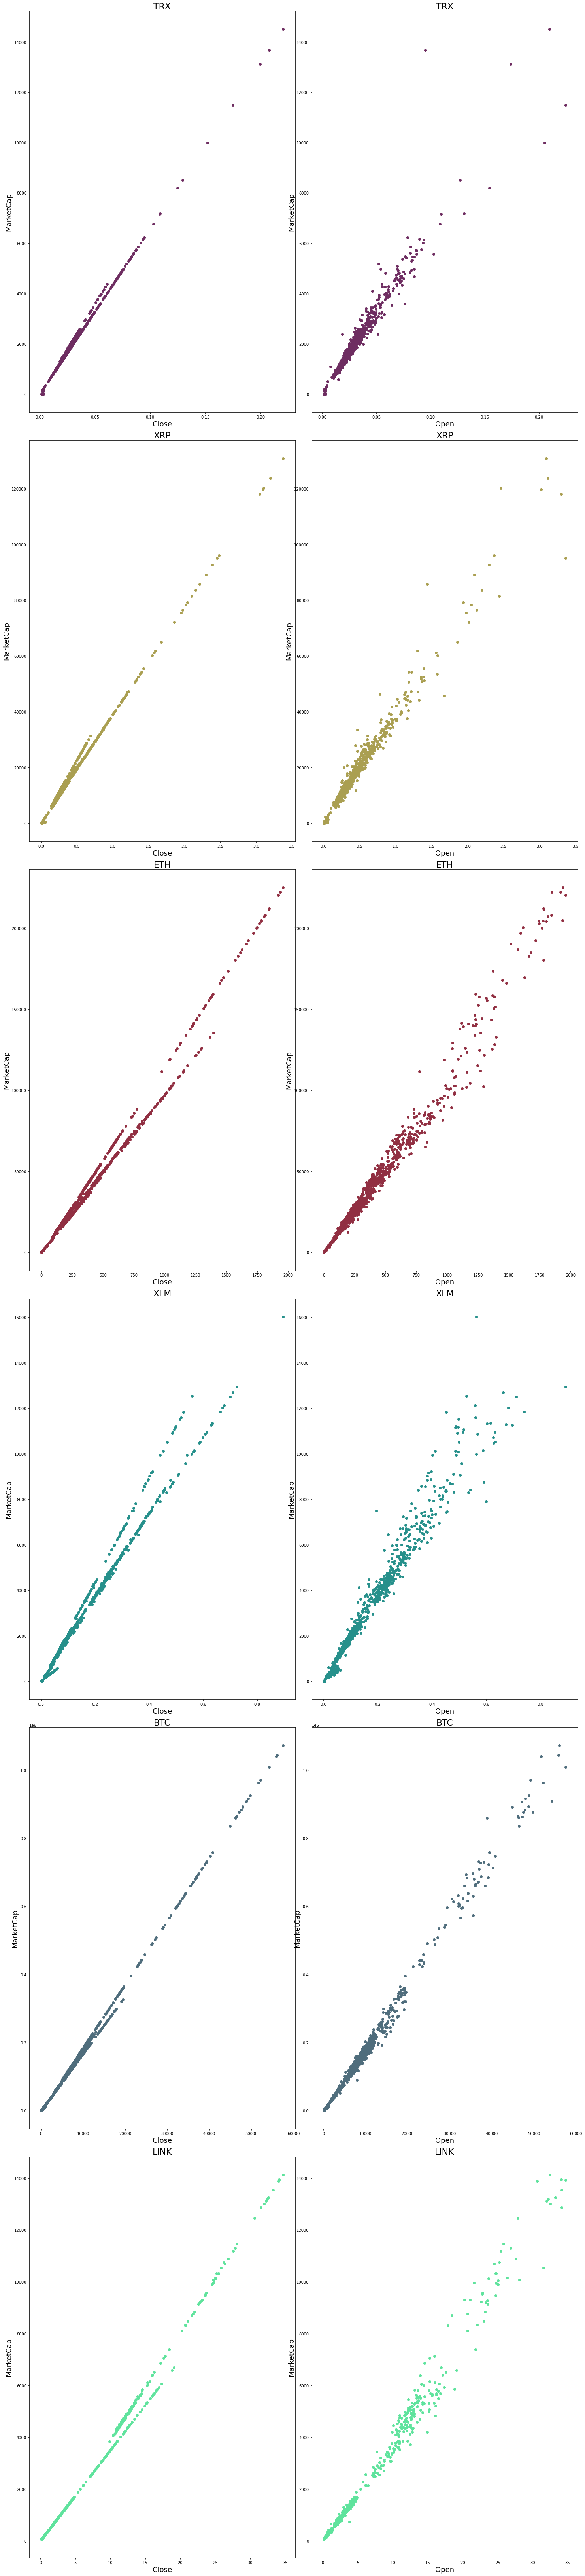

In [6]:
plotCoins([tron, xrp, eth, stell, bitcoin, link])

In [12]:
# Datas behave similar(part of data), thus the most convenient model should be the same for all cryptocurrencies mentioned

In [82]:
# prep function to get errors and best estimators
def prerRegression(coinDf, parameters, model):
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
#     parameters = {'alpha':[0.01, 0.1, 1, 2, 10],'normalize':[True, False]}
    grid=GridSearchCV(model, parameters)
    grid.fit(coinDf, y)
    pred_y=cross_val_predict(grid, coinDf, y, cv=10)
    plt.scatter(pred_y, y)
    err = np.mean(mean_squared_error(y, pred_y))
    return grid.best_estimator_, err

In [87]:
# Linear regression
def linearRegression(coinDf):
    parameters = {'fit_intercept':[True, False], 'normalize':[True, False]}
    model = LinearRegression()
    return prerRegression(coinDf, parameters, model)

(LinearRegression(fit_intercept=False, normalize=True), 0.0003128191790741869)

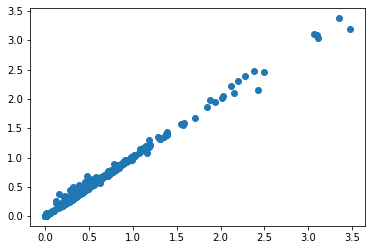

In [90]:
linearRegression(xrp)
# fit_intercept:False, normalize: True

In [21]:
# Polynomial regression
def polynomialRegression(coinDf):
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
    model = PolynomialFeatures(degree=3)
    coinDf=model.fit_transform(coinDf)
    rgr = LinearRegression();
    rgr.fit(coinDf, y)
    pred_y=rgr.predict(coinDf)
    plt.scatter(pred_y, y)
    err = np.mean(mean_squared_error(y, pred_y))
    return err

4.327241126283926e-05

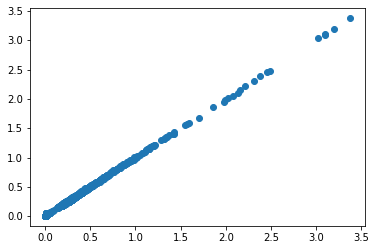

In [72]:
polynomialRegression(xrp)

In [91]:
# Ridge
def ridge(coinDf):
    model = Ridge()
    parameters = {'alpha':range(1,5), 'fit_intercept':[True, False],'normalize':[True, False]}
    return prerRegression(coinDf, parameters, model)

(Ridge(alpha=1, fit_intercept=False, normalize=True), 0.0003125487620465008)

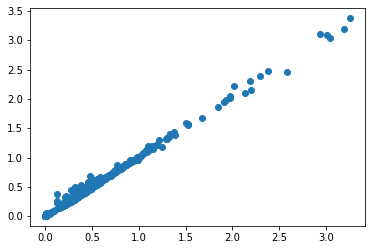

In [92]:
ridge(xrp)
# alpha=1, fit_intercept=False, normalize=True

In [93]:
# Lasso
def lasso(coinDf):    
    model = Lasso()
    parameters = {'alpha':[0.01, 0.1, 1, 2, 10],'normalize':[True, False]}
    return prerRegression(coinDf, parameters, model)

(Lasso(alpha=0.01), 0.0005099968590199571)

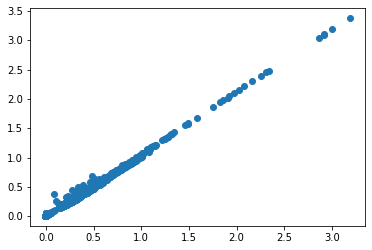

In [94]:
lasso(xrp)
# alpha=0.01, normalize=False

In [14]:
# The best model for this dataset according to the mean squared error is polynomial
# And now as we know that polynomial worked best, will use next function to predict currency close value

In [64]:
def closeValue(currencySymbol, highValue, lowValue, openValue, volumeValue, marketcapValue):
    coinDf = coinsDict[currencySymbol]
    y = coinDf['Close']
    coinDf = coinDf.drop(['Close', 'Symbol', 'Date'], axis=1)
    model = PolynomialFeatures(degree=3)
    coinDf=model.fit_transform(coinDf)
    rgr = LinearRegression();
    rgr.fit(coinDf, y)
    created = {
        'High': [highValue],
        'Low': [lowValue],
        'Open': [openValue],
        'Volume': [volumeValue],
        'Marketcap': [marketcapValue]
    }
    df = pd.DataFrame(created) 
    df=model.fit_transform(df)
    pred_y=rgr.predict(df)
    return pred_y[0]

In [68]:
closeValue('xrp',0.005980, 0.005613, 0.005875, 0, 43.877)

0.004514141469963952